In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import tensorflow as tf

_ = torch.manual_seed(42)

2022-12-18 12:24:42.440214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 12:24:44.052722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-18 12:24:44.052818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-18 12:24:44.052827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Create useful directories
We will first create all useful directories used to store figures, datas and models

In [2]:
!mkdir -p ../data
!mkdir -p ../figures
!mkdir -p ../models

# Helper functions

Here are the implementation of some usefull functions

In [3]:
def saveModel(model, model_name, date=True):    
    if date: filename = f'..Models/{model_name}_{datetime.now().strftime("%Y_%m_%d__%H_%M")})'
    else: filename = f'..Models/{model_name}'
    
    torch.save(model.state_dict(), filename)

In [4]:
def loadModel(model, model_name):
    model.load_state_dict(torch.load(f'./Models/{model_name}'))
    model.eval()
    return model

In [5]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=(15,15), 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 savefig=True, savedir=None):
    x,y = panelshape
    n_imgs = min(imgs.shape[0], n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if savefig and filename is not None: plt.savefig(f"{savedir}{title}.png")
    

In [6]:
# Divide dataset into batches

def divideInBatches(dataset, batch_size):
    # Train set
    n_batches = np.ceil(len(dataset)/batch_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader, n_batches,

In [7]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [8]:
def showimg(img, ax=None, shape=(28, 28), cmap='plasma', title="", fontsize=15, axis=False, savefig=True, savedir=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and filename is not None: plt.savefig(f"{filename}{savedir}.png")

In [9]:
device = chooseDevice()

GPU not available, CPU available


# Define datasets
We first download the fashionMNIST dataset using the dataset module of the pytorch library.
Then we reduce the model to 20% of its original size to have a lowerbound for our data augmentation performances.

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

full_train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
full_train_set_size = len(full_train_set)

In [11]:
reduction_factor = 0.05

idxs = np.random.choice(np.arange(full_train_set_size), int(full_train_set_size*reduction_factor) ,replace=False)

# Normalize the data from [-1. to 1.]
reduced_data  = full_train_set.data[idxs].float()
reduced_data /= reduced_data.max() - reduced_data.min()
reduced_data  = 2. * reduced_data - 1.

reduced_labels = full_train_set.targets[idxs]

In [12]:
reduced_train_set = torch.utils.data.TensorDataset(reduced_data, reduced_labels)
reduced_train_set_size = len(reduced_data)

In [13]:
# Delete some, now, useless variables
del reduction_factor, idxs

In [14]:
batch_size = 32

In [15]:
# Create base loader
full_train_loader,    full_train_n_batches    = divideInBatches(full_train_set, batch_size)
reduced_train_loader, reduced_train_n_batches = divideInBatches(reduced_train_set, batch_size)
test_loader,          test_n_batches          = divideInBatches(test_set, batch_size)

# Model definition
Here we will define the architecture of our models

## CNN model

In [16]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

# Training of the CNN

In [17]:
n_epoch_cnn = 5
n_classes = len(full_train_set.classes)

In [18]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

In [19]:
def evaluate_raw_performances(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
                              losses_train, accuracies_train, accuracies_test, 
                              loss_function, optimizer):
    cnn.eval()
    for batch_id, (data, labels) in enumerate(train_loader):
        data = data.reshape((-1,1,28,28))
        data = data.to(device)
        labels = labels.to(device)

        pred = cnn(data)

        labels_pred, labels_prob, _ = cnn.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)

        loss = loss_function(labels_prob, target_prob)
        
        optimizer.zero_grad()
        
        losses_train[0] += loss.item()
        accuracies_train[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train[0] /= train_n_batches
    losses_train[0] /= train_n_batches

    cnn.eval()
    for batch_id, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        pred = cnn(data)

        labels_pred, _, _ = cnn.predictLabels(pred)

        accuracies_test[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test[0] /= test_n_batches

    print(f"Accuracy during training: {accuracies_train[0]*100:.2f}%")
    print(f"Accuracy during test:     {accuracies_test[0]*100:.2f}%")
    print(f"Loss during training:     {losses_train[0]:.2f}")

In [20]:
def train_cnn(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
              losses_train, accuracies_train, accuracies_test, 
              loss_function, optimizer, n_epoch):
    # Training of the CNN
    for epoch in range(n_epoch):
        cnn.train()
        for batch_id, (data, labels) in enumerate(train_loader):
            data = data.reshape((-1,1,28,28))
            data = data.to(device)
            labels = labels.to(device)

            pred = cnn(data)

            labels_pred, labels_prob, _ = cnn.predictLabels(pred)

            target_prob = torch.zeros_like(labels_prob)
            for i,j in enumerate(labels):
                target_prob[i][j] = 1
            target_prob = target_prob.to(device)

            loss = loss_function(labels_prob, target_prob)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_train[epoch + 1] += loss.item()
            accuracies_train[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_train[epoch + 1] /= train_n_batches
        losses_train[epoch + 1] /= train_n_batches

        cnn.eval()
        for batch_id, (real, labels) in enumerate(test_loader):
            real = real.to(device)
            labels = labels.to(device)
            pred = cnn(real)

            labels_pred, _, _ = cnn.predictLabels(pred)

            accuracies_test[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_test[epoch + 1] /= test_n_batches

        print(f"Epoch [{epoch + 1:2d}/{n_epoch:2d}] \
                Accuracy: {accuracies_test[epoch + 1]:.4f} \
                Loss:     {losses_train[epoch + 1]:.4f}")

## Train CNN on full data set

In [21]:
cnn_full = CNN(n_classes).to(device=device)

In [22]:
# Loss function for the CNN
loss_function_cnn_full = nn.CrossEntropyLoss()

In [23]:
# Adam optimization parameters
lr_cnn_full = 0.001
betas_cnn_full = (0.9, 0.999)

optimizer_cnn_full = torch.optim.Adam(cnn_full.parameters(), lr=lr_cnn_full, betas = betas_cnn_full)

In [24]:
%%time

# Error metrics at initialisation

losses_train_cnn_full     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_full = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_full  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
                          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
                          loss_function_cnn_full, optimizer_cnn_full)
print()

Accuracy during training: 4.88%
Accuracy during test:     4.88%
Loss during training:     2.35

CPU times: user 38.5 s, sys: 68.7 ms, total: 38.5 s
Wall time: 25.6 s


In [25]:
%%time
train_cnn(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
          loss_function_cnn_full, optimizer_cnn_full,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/ 5]                 Accuracy: 0.8710                 Loss:     1.6298
Epoch [ 2/ 5]                 Accuracy: 0.8916                 Loss:     1.5769
Epoch [ 3/ 5]                 Accuracy: 0.8913                 Loss:     1.5642
Epoch [ 4/ 5]                 Accuracy: 0.8997                 Loss:     1.5563
Epoch [ 5/ 5]                 Accuracy: 0.9037                 Loss:     1.5495

CPU times: user 5min 1s, sys: 695 ms, total: 5min 2s
Wall time: 3min 2s


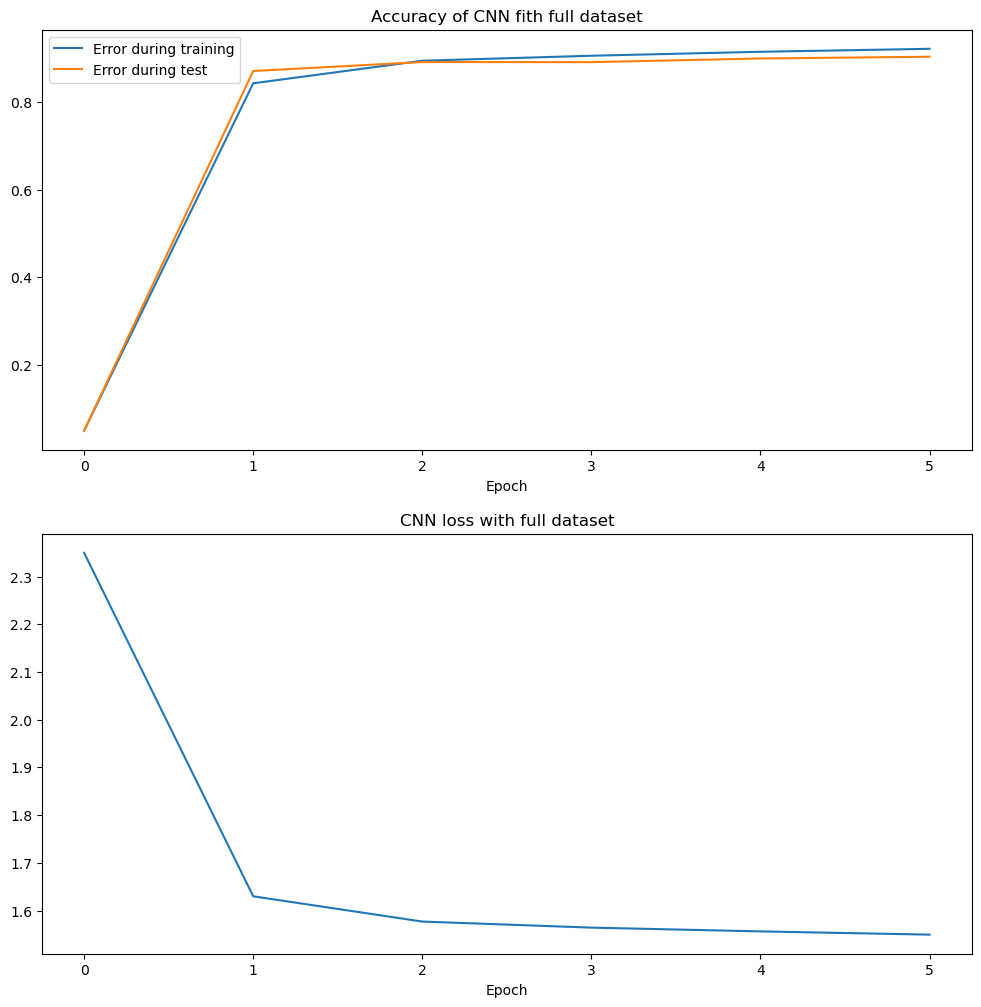

In [26]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn_full, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn_full, label = "Error during test")
ax1.set_title('Accuracy of CNN fith full dataset')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn_full)
ax2.set_title('CNN loss with full dataset')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Metrics_full.png")

In [27]:
# Delete some, now, useless variables
del loss_function_cnn_full, lr_cnn_full, betas_cnn_full, optimizer_cnn_full

## Train CNN on reduced data set

In [28]:
cnn_reduced = CNN(n_classes).to(device=device)

In [29]:
# Loss function for the CNN
loss_function_cnn_reduced = nn.CrossEntropyLoss()

In [30]:
# Adam optimization parameters
lr_cnn_reduced = 0.001
betas_cnn_reduced = (0.9, 0.999)

optimizer_cnn_reduced = torch.optim.Adam(cnn_reduced.parameters(), lr=lr_cnn_reduced, betas = betas_cnn_reduced)

In [31]:
%%time

# Error metrics at initialisation

losses_train_cnn_reduced     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_reduced = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_reduced  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
                          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
                          loss_function_cnn_reduced, optimizer_cnn_reduced)

print()

Accuracy during training: 13.28%
Accuracy during test:     14.42%
Loss during training:     2.31

CPU times: user 7.94 s, sys: 35.9 ms, total: 7.98 s
Wall time: 5.07 s


In [32]:
%%time
train_cnn(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
          loss_function_cnn_reduced, optimizer_cnn_reduced,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/ 5]                 Accuracy: 0.7268                 Loss:     1.9220
Epoch [ 2/ 5]                 Accuracy: 0.7918                 Loss:     1.6951
Epoch [ 3/ 5]                 Accuracy: 0.8095                 Loss:     1.6496
Epoch [ 4/ 5]                 Accuracy: 0.8151                 Loss:     1.6241
Epoch [ 5/ 5]                 Accuracy: 0.8351                 Loss:     1.6091

CPU times: user 38.5 s, sys: 92.5 ms, total: 38.6 s
Wall time: 23.3 s


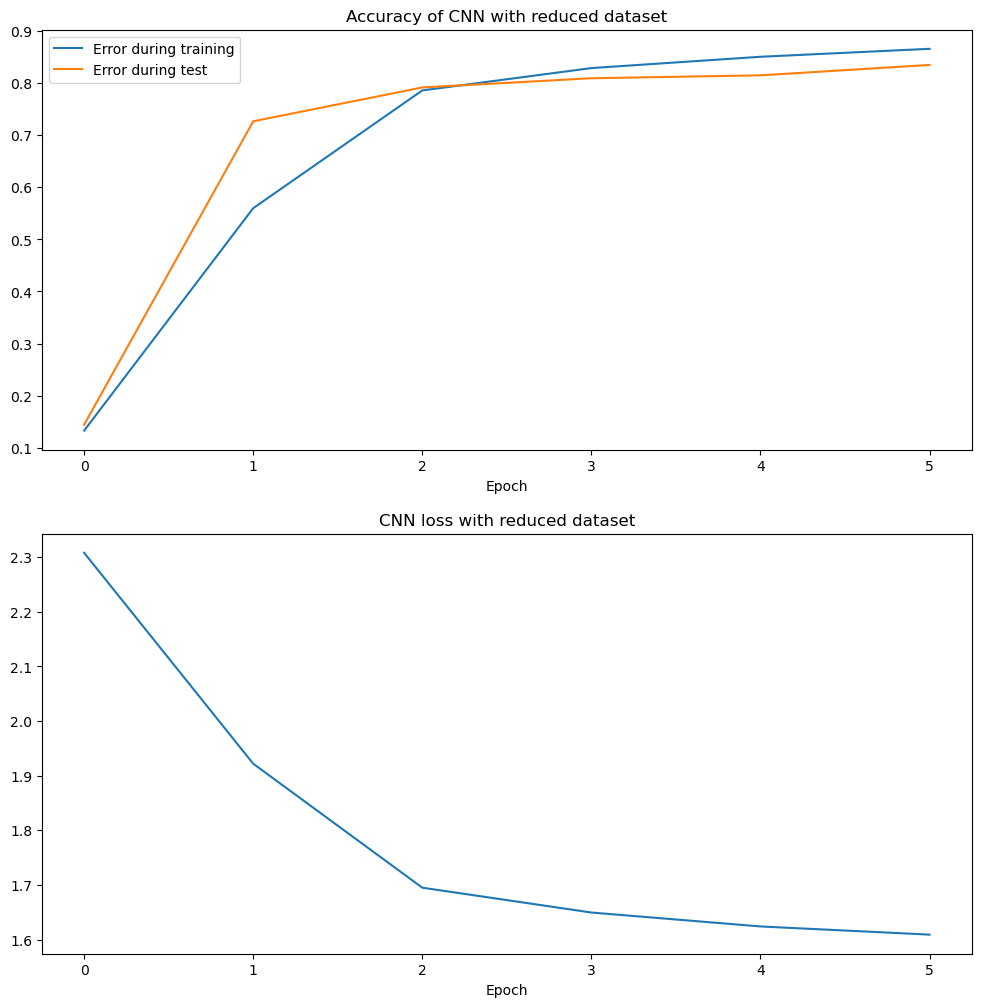

In [33]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn_reduced, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn_reduced, label = "Error during test")
ax1.set_title('Accuracy of CNN with reduced dataset')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn_reduced)
ax2.set_title('CNN loss with reduced dataset')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Metrics_reduced.png")

In [34]:
# Delete some, now, useless variables
del loss_function_cnn_reduced, lr_cnn_reduced, betas_cnn_reduced, optimizer_cnn_reduced

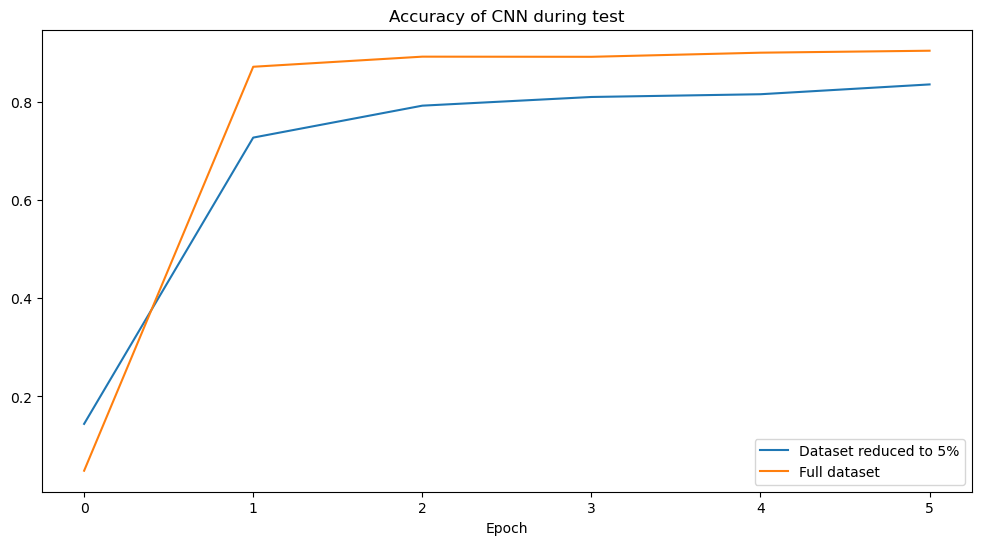

In [35]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig,  ax1= plt.subplots(1, 1, figsize=(12,6))

ax1.plot(epochs, accuracies_test_cnn_reduced, label = "Dataset reduced to 5%")
ax1.plot(epochs, accuracies_test_cnn_full, label = "Full dataset")
ax1.set_title('Accuracy of CNN during test')
ax1.set_xlabel('Epoch')
ax1.legend()

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Accuracy_comparison.png")

# Data augmentation
In this section we will explore mutliple data augmentation techniques and observe their effect on the CNN models

In [47]:
train_set_rotated = []
#make 10 random rotation (max ±20 deg) on the reduced train set
for j in range(10):
    train_set_rotated.append(tf.keras.preprocessing.image.random_rotation(reduced_data, 20, row_axis=1, col_axis=2, channel_axis=0))

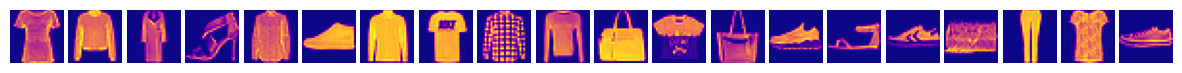

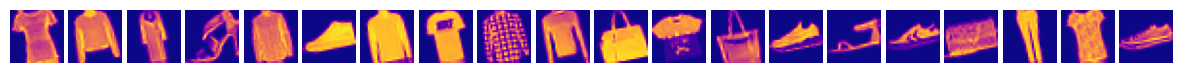

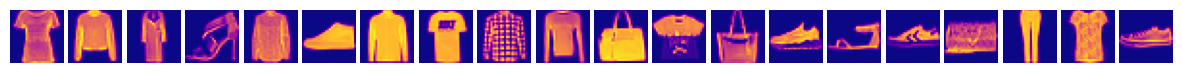

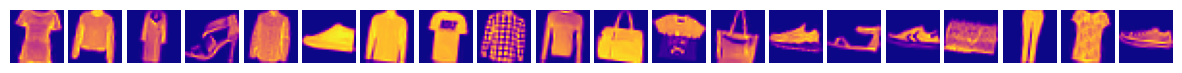

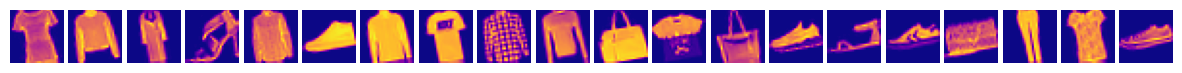

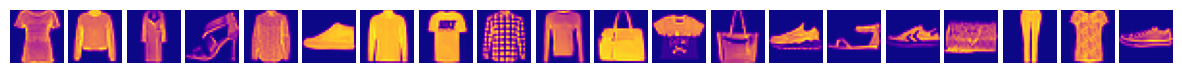

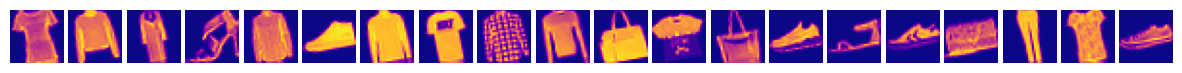

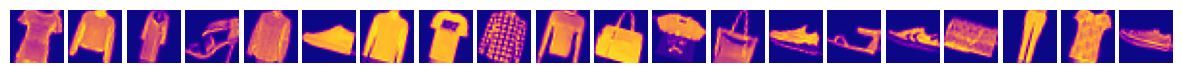

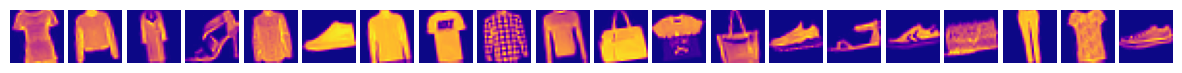

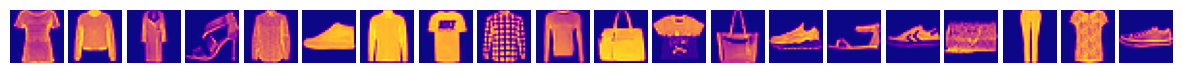

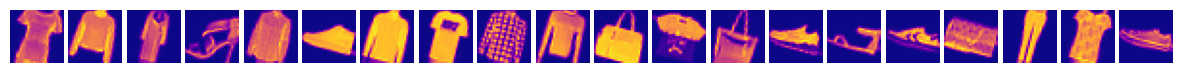

In [51]:
#show the first 20 original imgs and the 10 random rotation maked on it
showimgpanel(reduced_data,20,(1,20),savefig=False)
for j in range(10):
    showimgpanel(train_set_rotated[j],20,(1,20),savefig=False)

In [69]:
#flip image left to right on reduced train set
train_set_flip = []
for i in range(len(reduced_data)):
    train_set_flip.append(np.fliplr(reduced_data[i]))
train_set_flip = np.asarray(train_set_flip)

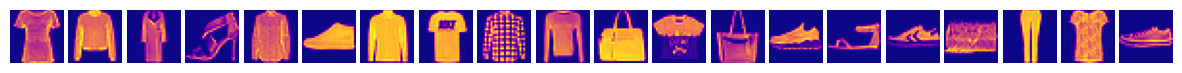

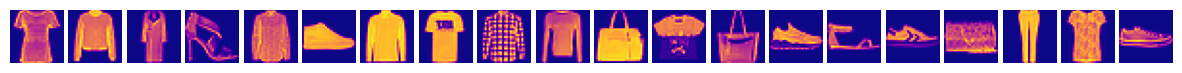

In [70]:
#show first 20 original and flipped imgs
showimgpanel(reduced_data,20,(1,20),savefig=False)
showimgpanel(train_set_flip,20,(1,20),savefig=False)

In [71]:
train_set_noisy = []
mean = 0
std = 0.1
#make 10 noisy version based on the original with differents std
for i in range(1,11):
    noise = np.random.normal(mean, i*std, reduced_data.shape)
    noise_image = reduced_data + noise
    train_set_noisy.append(noise_image)

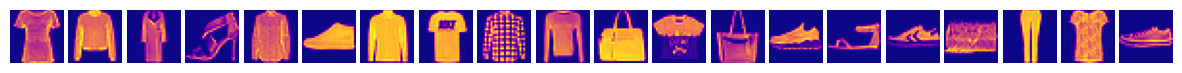

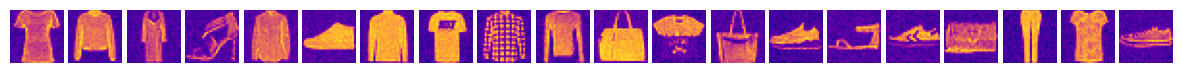

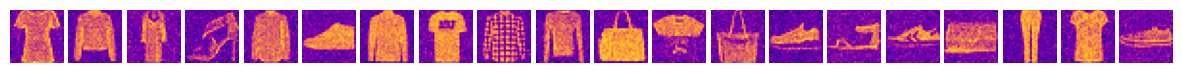

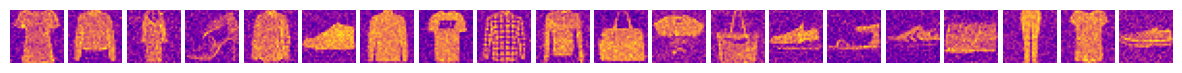

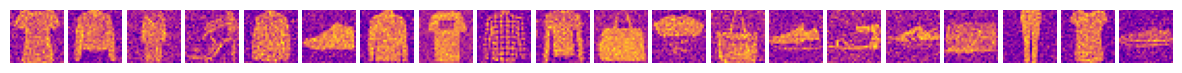

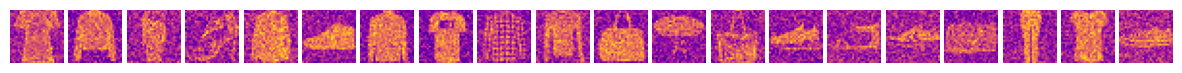

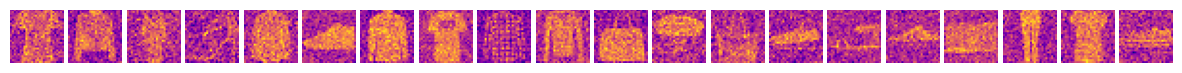

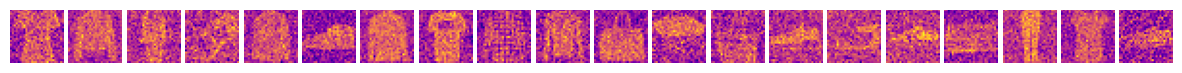

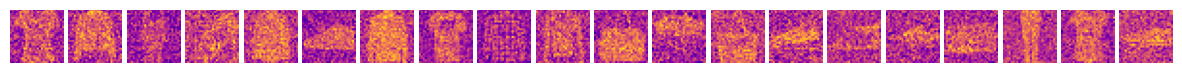

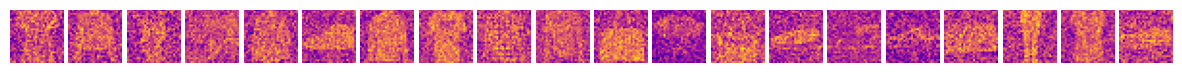

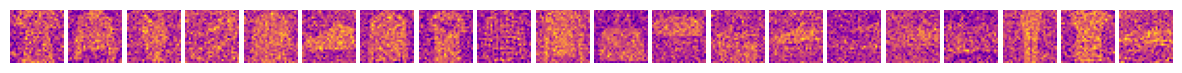

In [72]:
# show the first 20 original imgs and noisy versions
showimgpanel(reduced_data,20,(1,20),savefig=False)
for j in range(10):
    showimgpanel(train_set_noisy[j],20,(1,20),savefig=False)
    

## Synthetic Minority Over-sampling Technique (SMOTE)
SMOTE (Synthetic Minority Oversampling Technique) is a popular technique for oversampling in imbalanced data sets in machine learning. It is used to synthesize new minority class examples in order to increase the number of minority class instances and balance the class distribution.

The goal of SMOTE is to address the issue of imbalanced data sets, where one class (the minority class) is significantly underrepresented compared to the other class (the majority class). In such cases, machine learning algorithms can often have a biased learning towards the majority class, leading to poor performance on the minority class. By synthesizing new minority class examples, SMOTE helps to balance the class distribution and improve the performance of the model on the minority class.

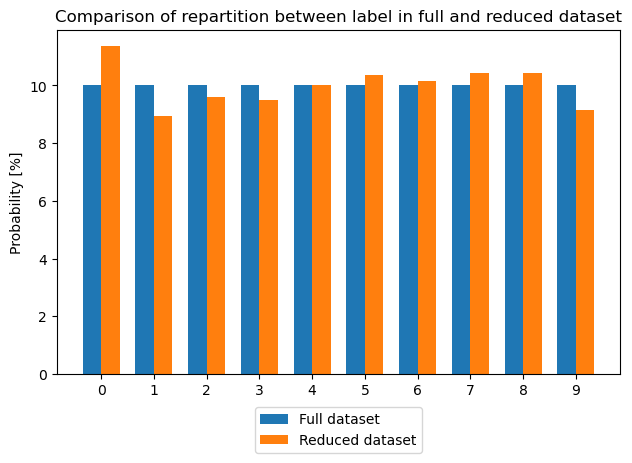

In [73]:
reduced_train_set.tensors[1]

n_full = np.zeros(n_classes)
n_reduced = np.zeros(n_classes)
for label in range(n_classes):
    n_full[label] = torch.sum((full_train_set.targets == label).int())
    n_reduced[label] = torch.sum((reduced_train_set.tensors[1] == label).int())

p_full = n_full/full_train_set_size
p_reduced = n_reduced/reduced_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x + width/2, p_reduced*100, width, label='Reduced dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.25))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_initial")
plt.show()


We can observe that the full fashion MNIST dataset is perfectly balanced. We are going to apply SMOTE methode to balance our reduced dataset.

In [74]:
smote_data = torch.clone(reduced_data)
smote_labels = torch.clone(reduced_labels)

In [75]:
n_max = int(np.max(n_reduced))

for label in range(n_classes):
    idxs = np.arange(reduced_train_set_size)[reduced_train_set.tensors[1]==label]
    
    n_missing = int(n_max-n_reduced[label])
    print(f"\nGenerating {n_missing:2d} images of label '{full_train_set.classes[label]}' with 10% of the set")
    for i in range(n_missing):
        idxs = np.random.choice(np.arange(n_classes), int(n_reduced[label]*0.1))
        smote_data = torch.vstack((smote_data, torch.mean(reduced_data[idxs], dim=0).reshape((1,28,28))))
        smote_labels = torch.hstack((smote_labels, torch.tensor([label])))


Generating  0 images of label 'T-shirt/top' with 10% of the set

Generating 73 images of label 'Trouser' with 10% of the set

Generating 53 images of label 'Pullover' with 10% of the set

Generating 56 images of label 'Dress' with 10% of the set

Generating 40 images of label 'Coat' with 10% of the set

Generating 30 images of label 'Sandal' with 10% of the set

Generating 36 images of label 'Shirt' with 10% of the set

Generating 28 images of label 'Sneaker' with 10% of the set

Generating 28 images of label 'Bag' with 10% of the set

Generating 66 images of label 'Ankle boot' with 10% of the set


In [76]:
smote_train_set = torch.utils.data.TensorDataset(smote_data, smote_labels)
smote_train_set_size = len(smote_data)

smote_train_loader, smote_train_n_batches = divideInBatches(smote_train_set, batch_size)

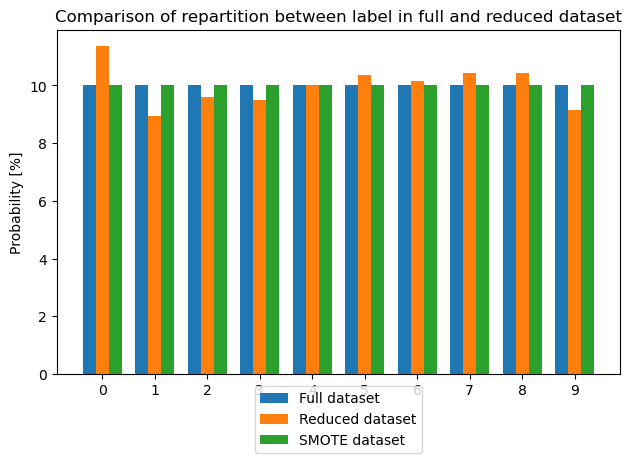

In [77]:
reduced_train_set.tensors[1]

n_smote = np.zeros(n_classes)
for label in range(n_classes):
    n_smote[label] = torch.sum((smote_labels == label).int())

p_smote = n_smote/smote_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x , p_reduced*100, width, label='Reduced dataset')
rects3 = ax.bar(x + width, p_smote*100, width, label='SMOTE dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.25))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_smote")
plt.show()

The dataset obtained after SMOTE method is indeed balanced as we can see. This dataset does now contain:

In [78]:
print(f"{smote_train_set_size} records. It corresponds to an augmentation of +{100.*(smote_train_set_size/reduced_train_set_size-1.):.2f}% in comparison to the initial reduced dataset.")

3410 records. It corresponds to an augmentation of +13.67% in comparison to the initial reduced dataset.


In [79]:
cnn_smote = CNN(n_classes).to(device=device)
# Loss function for the CNN
loss_function_cnn_smote = nn.CrossEntropyLoss()
# Adam optimization parameters
lr_cnn_smote = 0.001
betas_cnn_smote = (0.9, 0.999)

optimizer_cnn_smote = torch.optim.Adam(cnn_smote.parameters(), lr=lr_cnn_smote, betas = betas_cnn_smote)

In [80]:
%%time

# Error metrics at initialisation

losses_train_cnn_smote     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_smote = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_smote  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
                          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
                          loss_function_cnn_smote, optimizer_cnn_smote)

print()

Accuracy during training: 9.42%
Accuracy during test:     9.86%
Loss during training:     2.32

CPU times: user 7.59 s, sys: 25.1 ms, total: 7.61 s
Wall time: 4.9 s


In [81]:
%%time
train_cnn(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
          loss_function_cnn_smote, optimizer_cnn_smote,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

Epoch [ 1/ 5]                 Accuracy: 0.7238                 Loss:     1.9801
Epoch [ 2/ 5]                 Accuracy: 0.7965                 Loss:     1.7693
Epoch [ 3/ 5]                 Accuracy: 0.8108                 Loss:     1.7265
Epoch [ 4/ 5]                 Accuracy: 0.8318                 Loss:     1.7012
Epoch [ 5/ 5]                 Accuracy: 0.8329                 Loss:     1.6819

CPU times: user 39.9 s, sys: 99.7 ms, total: 40 s
Wall time: 24.3 s
